<a href="https://colab.research.google.com/github/GKSJ-Deepvision/AI-DeepVision/blob/Anvitha_Bolakonda/Task_3(Crowd).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fine Tuning the existing model**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from tqdm import tqdm


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [5]:
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, 1)
        )

    def forward(self, x):
        return self.backend(self.frontend(x))


In [6]:
model = CSRNet().to(device)

checkpoint_path = "/content/drive/MyDrive/deepvision/checkpoints_partB/partB_best.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

print("✅ CSRNet loaded")


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:06<00:00, 86.1MB/s]


✅ CSRNet loaded


In [7]:
VIDEO_DIR = "/content/drive/MyDrive/deepvision/archive (3)"
SAVE_DIR  = "/content/drive/MyDrive/deepvision/CSRNet_Training/fast_video_epochs"
os.makedirs(SAVE_DIR, exist_ok=True)


In [8]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [9]:
cached_data = []

model.eval()
print("📦 Caching pseudo-labels...")

for video in os.listdir(VIDEO_DIR):
    if not video.endswith(".mp4"):
        continue

    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # 🔥 resize = huge speedup
        frame = cv2.resize(frame, (640, 360))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        img = transform(frame).unsqueeze(0).to(device)

        with torch.no_grad():
            density = model(img)
            pseudo_count = density.sum().detach()

        cached_data.append((img.cpu(), pseudo_count.cpu()))

    cap.release()

print(f"✅ Cached frames: {len(cached_data)}")


📦 Caching pseudo-labels...
✅ Cached frames: 2221


In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    print(f"\n🔁 Epoch {epoch+1}/{EPOCHS}")

    for img, pseudo_count in tqdm(cached_data):
        img = img.to(device)
        pseudo_count = pseudo_count.to(device)

        optimizer.zero_grad()

        density = model(img)
        pred_count = density.sum()

        loss = criterion(pred_count, pseudo_count)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(cached_data)
    print(f"📘 Epoch {epoch+1} | Avg Loss: {avg_loss:.6f}")

    # Save checkpoint
    ckpt_path = os.path.join(
        SAVE_DIR, f"csrnet_fast_video_epoch_{epoch+1}.pth"
    )

    torch.save({
        "epoch": epoch + 1,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": avg_loss
    }, ckpt_path)

    print(f"💾 Saved: {ckpt_path}")



🔁 Epoch 1/5


100%|██████████| 2221/2221 [05:12<00:00,  7.10it/s]


📘 Epoch 1 | Avg Loss: 4551.525528
💾 Saved: /content/drive/MyDrive/deepvision/CSRNet_Training/fast_video_epochs/csrnet_fast_video_epoch_1.pth

🔁 Epoch 2/5


100%|██████████| 2221/2221 [05:11<00:00,  7.13it/s]


📘 Epoch 2 | Avg Loss: 3655.098007
💾 Saved: /content/drive/MyDrive/deepvision/CSRNet_Training/fast_video_epochs/csrnet_fast_video_epoch_2.pth

🔁 Epoch 3/5


100%|██████████| 2221/2221 [05:10<00:00,  7.16it/s]


📘 Epoch 3 | Avg Loss: 2638.349383
💾 Saved: /content/drive/MyDrive/deepvision/CSRNet_Training/fast_video_epochs/csrnet_fast_video_epoch_3.pth

🔁 Epoch 4/5


100%|██████████| 2221/2221 [05:09<00:00,  7.18it/s]


📘 Epoch 4 | Avg Loss: 1838.354836
💾 Saved: /content/drive/MyDrive/deepvision/CSRNet_Training/fast_video_epochs/csrnet_fast_video_epoch_4.pth

🔁 Epoch 5/5


100%|██████████| 2221/2221 [05:09<00:00,  7.17it/s]


📘 Epoch 5 | Avg Loss: 1301.796755
💾 Saved: /content/drive/MyDrive/deepvision/CSRNet_Training/fast_video_epochs/csrnet_fast_video_epoch_5.pth


In [11]:
FINAL_MODEL_PATH = "/content/drive/MyDrive/deepvision/CSRNet_Training/fast_video_epochs/csrnet_video_finetuned_final.pth"

torch.save(model.state_dict(), FINAL_MODEL_PATH)

print("✅ Final fine-tuned CSRNet model saved")
print("📍 Path:", FINAL_MODEL_PATH)


✅ Final fine-tuned CSRNet model saved
📍 Path: /content/drive/MyDrive/deepvision/CSRNet_Training/fast_video_epochs/csrnet_video_finetuned_final.pth


In [12]:
import numpy as np
from tqdm import tqdm

model.eval()

preds = []
gts = []

with torch.no_grad():
    for img, pseudo_count in tqdm(cached_data, desc="Evaluating"):
        img = img.to(device)
        pseudo_count = pseudo_count.to(device)

        density = model(img)
        pred_count = density.sum()

        preds.append(pred_count.item())
        gts.append(pseudo_count.item())

preds = np.array(preds)
gts   = np.array(gts)

mae = np.mean(np.abs(preds - gts))
rmse = np.sqrt(np.mean((preds - gts) ** 2))

print("📊 MAE :", mae)
print("📊 RMSE:", rmse)


Evaluating: 100%|██████████| 2221/2221 [01:38<00:00, 22.53it/s]

📊 MAE : 112.84240999636867
📊 RMSE: 159.54829559371032


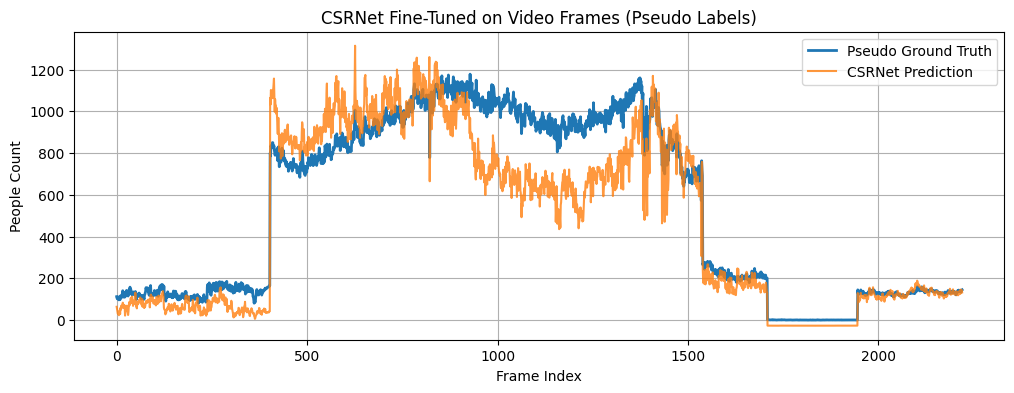

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# extract pseudo ground-truth counts
gt_pseudo = np.array([gt.item() for _, gt in cached_data])

plt.figure(figsize=(12, 4))
plt.plot(gt_pseudo, label="Pseudo Ground Truth", linewidth=2)
plt.plot(preds, label="CSRNet Prediction", alpha=0.8)
plt.legend()
plt.xlabel("Frame Index")
plt.ylabel("People Count")
plt.title("CSRNet Fine-Tuned on Video Frames (Pseudo Labels)")
plt.grid(True)
plt.show()


**Testing Model on Multiple Videos**

In [15]:
import cv2
import torch
import time
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
import torch.nn as nn
import torchvision.models as models
import os


In [18]:
import torch
import torch.nn as nn
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()

        # ✅ MUST be VGG16 with BatchNorm
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)

        # ✅ frontend exactly as training
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        # ✅ backend exactly as training
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, 1)   # 🔑 CRITICAL
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CSRNet().to(device)

FINAL_MODEL_PATH = "/content/drive/MyDrive/deepvision/CSRNet_Training/fast_video_epochs/csrnet_video_finetuned_final.pth"

model.load_state_dict(torch.load(FINAL_MODEL_PATH, map_location=device))
model.eval()

print("✅ CSRNet final model loaded successfully")


✅ CSRNet final model loaded successfully


In [20]:
def preprocess_frame(frame):
    frame_resized = cv2.resize(frame, (1024, 768))
    frame_resized = frame_resized / 255.0
    frame_resized = frame_resized.transpose(2, 0, 1)
    tensor = torch.tensor(frame_resized, dtype=torch.float32).unsqueeze(0).to(device)
    return tensor


In [44]:
def csrnet_count(frame):
    # -------- PREPROCESS --------
    h, w, _ = frame.shape

    # resize for CSRNet (IMPORTANT)
    resized = cv2.resize(frame, (640, 480))
    resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    resized = resized / 255.0

    img = torch.from_numpy(resized).permute(2, 0, 1).unsqueeze(0).float().to(device)

    # normalize (VERY IMPORTANT)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)
    img = (img - mean) / std

    # -------- MODEL --------
    with torch.no_grad():
        density = model(img)[0, 0]

    density = density.cpu().numpy()
    density = np.maximum(density, 0)

    # -------- CORRECT COUNT --------
    count = density.sum()

    # -------- HEATMAP --------
    heatmap = density / (density.max() + 1e-6)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (w, h))

    overlay = cv2.addWeighted(frame, 0.6, heatmap, 0.4, 0)

    # -------- ALERT --------
    if count < 50:
        alert = "SAFE"
        color = (0, 255, 0)
    elif count < 150:
        alert = "MODERATE"
        color = (0, 255, 255)
    else:
        alert = "CROWD ALERT"
        color = (0, 0, 255)

    cv2.putText(
        overlay,
        f"Count: {count:.1f} | {alert}",
        (30, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.4,
        color,
        4
    )

    return overlay, count, alert


In [32]:
INPUT_VIDEO_DIR = INPUT_VIDEO_DIR = "/content/drive/MyDrive/deepvision/archive (3)"

OUTPUT_VIDEO_DIR = "/content/drive/MyDrive/deepvision/CSRNet_Training/csrnet_out"

os.makedirs(OUTPUT_VIDEO_DIR, exist_ok=True)
print("Folder created:", OUTPUT_VIDEO_DIR)


Folder created: /content/drive/MyDrive/deepvision/CSRNet_Training/csrnet_out


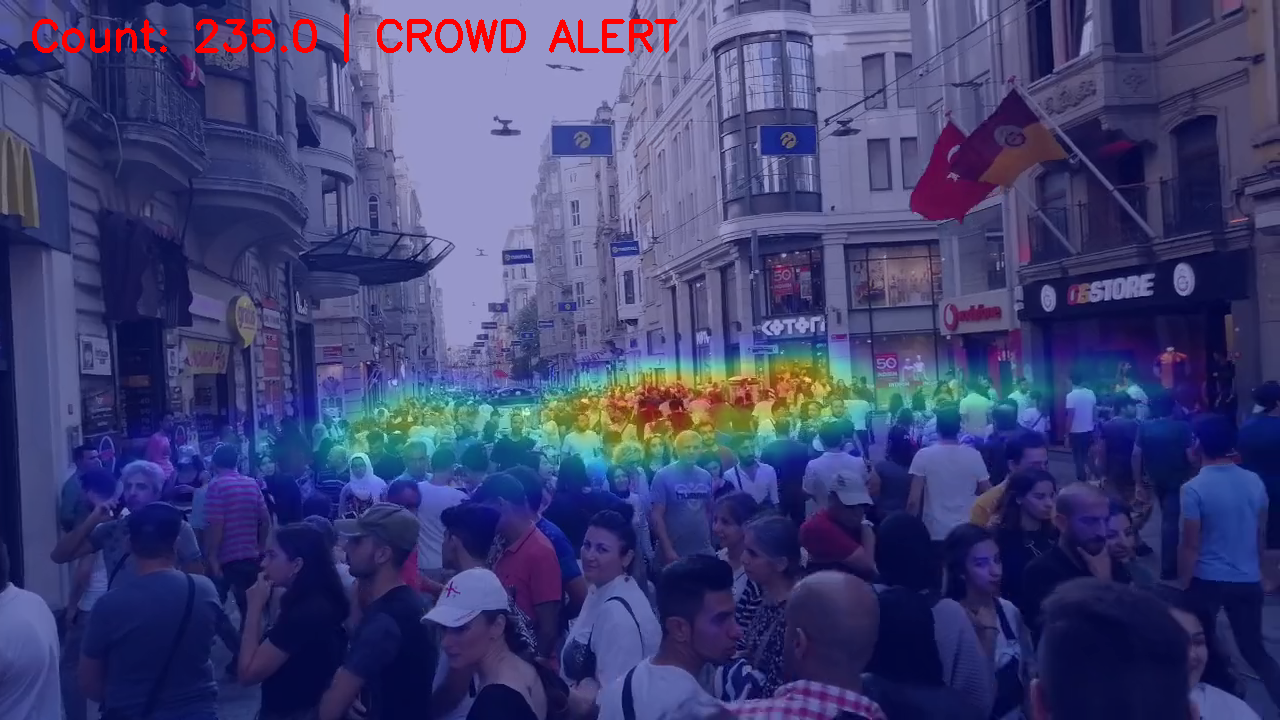

🎬 Video: production_id_4196258 (720p).mp4
🎞 Frame: 275/275
📊 Progress: 100.0%
👥 Count: 235.0 | CROWD ALERT
⏳ Elapsed: 29.6s
⏱ ETA: 0.0s
✅ Finished: production_id_4196258 (720p).mp4
📁 Saved as: /content/drive/MyDrive/deepvision/CSRNet_Training/csrnet_out/production_id_4196258 (720p)_csrnet_out.mp4

🎉 All videos processed successfully!


In [45]:
videos = [v for v in os.listdir(INPUT_VIDEO_DIR) if v.endswith(".mp4")]
print("🎥 Videos found:", videos)

for video_name in videos:

    VIDEO_PATH = os.path.join(INPUT_VIDEO_DIR, video_name)
    OUTPUT_PATH = os.path.join(
        OUTPUT_VIDEO_DIR,
        video_name.replace(".mp4", "_csrnet_out.mp4")
    )

    cap = cv2.VideoCapture(VIDEO_PATH)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (w, h))

    frame_id = 0
    start_time = time.time()

    print(f"\n🚀 Processing video: {video_name}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        processed, count, alert = csrnet_count(frame)
        out.write(processed)

        frame_id += 1

        if frame_id % 5 == 0:
            elapsed = time.time() - start_time
            avg = elapsed / frame_id
            remaining = (total_frames - frame_id) * avg
            progress = (frame_id / total_frames) * 100

            rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
            clear_output(wait=True)
            display(Image.fromarray(rgb))

            print(f"🎬 Video: {video_name}")
            print(f"🎞 Frame: {frame_id}/{total_frames}")
            print(f"📊 Progress: {progress:.1f}%")
            print(f"👥 Count: {count:.1f} | {alert}")
            print(f"⏳ Elapsed: {elapsed:.1f}s")
            print(f"⏱ ETA: {remaining:.1f}s")

    cap.release()
    out.release()

    print(f"✅ Finished: {video_name}")
    print(f"📁 Saved as: {OUTPUT_PATH}")

print("\n🎉 All videos processed successfully!")
